## Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import mysql.connector
import re
import nltk
import joblib
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Bidirectional, Dense
from keras_tuner import RandomSearch, Hyperband
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
import spacy
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Fetch News Data

In [5]:
# Fetch news data from MySQL
def fetch_news_from_mysql():
    try:
        conn = mysql.connector.connect(
            host='localhost',
            user='root',
            password='Ariyarathne99@',
            database='crypto_news'
        )
        query = "SELECT date, headline, description FROM ada_news"
        news_data = pd.read_sql_query(query, conn)
        conn.close()
        return news_data
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

news_data = fetch_news_from_mysql()

C:\Users\acer\AppData\Local\Temp\ipykernel_20696\862600701.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  news_data = pd.read_sql_query(query, conn)


In [6]:
news_data

,date,headline,description
0,"Jan 01, 2025","Hive Digital Relocates HQ to Texas, Citing Pro...",Bitcoin mining firm Hive Digital Technologies ...
1,"Dec 16, 2024","Bitcoin Soars Past $106,000 Amid Hopes of U.S....","Bitcoin surged to an all-time high above $106,..."
2,"Dec 13, 2024",Japanese Lawmaker Asks Government to Create Na...,A Japanese lawmaker has asked the government t...
3,"Nov 28, 2024",ETH Co-Founder Charles Hoskinson Predicts Bitc...,Ethereum blockchain and Cardano founder Charle...
4,"Nov 11, 2024",Bitcoin Hits New High Over $82k on Hopes of Tr...,"Bitcoin reached a record high above $82,000 on..."
...,...,...,...
1558,"Mar 07, 2025",Crypto and Social Media Scams Top Investor Thr...,The North American Securities Administrators A...
1559,"Mar 16, 2025",Coinbase Seeks Approval to Launch Cardano and ...,Coinbase is moving to expand its derivatives o...
1560,"Mar 19, 2025",Swiss Zuger Kantonalbank Adds Cardano and Aval...,"On March 17, 2025, Zuger Kantonalbank, a Swiss..."
1561,"Mar 21, 2025",Japan’s Metaplanet Appoints Eric Trump to New ...,Tokyo-based Bitcoin-stacking company Metaplane...


## Preprocess News Data

In [8]:
# Load spaCy NLP model (efficient lemmatization)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Load Loughran-McDonald Finance Sentiment Dictionary
lm_positive = {    "gain", "growth", "bullish", "opportunity", "profit", "surge", "expansion",
    "adoption", "approval", "partnership", "innovation", "mainstream", "rally",
    "institutional", "breakthrough", "stability", "strong", "all-time-high",
    "liquidity", "halving", "scarcity", "whale accumulation", "stake", "integration",
    "etf approval", "layer 2 scaling", "metaverse expansion", "positive outlook"}

lm_negative = {"crash", "loss", "bearish", "decline", "debt", "bankruptcy", "downturn",
    "regulatory crackdown", "ban", "fud", "lawsuit", "hacked", "ponzi",
    "liquidation", "fraud", "scam", "rug pull", "dumping", "sell-off",
    "volatility", "delisting", "depeg", "inflation", "recession", "exchange insolvency",
    "crypto winter", "negative outlook"}

def preprocess_text(text):
    """Cleans, removes stopwords, and lemmatizes input text."""
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  
    text = re.sub(r"[^a-zA-Z\s]", "", text)  
    text = re.sub(r"\s+", " ", text).strip()  
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

def financial_sentiment_adjustment(text, vader_score):
    """Adjust sentiment score using the Loughran-McDonald financial lexicon."""
    words = text.split()
    adjustment = sum(0.2 if word in lm_positive else -0.2 if word in lm_negative else 0 for word in words)
    return max(min(vader_score + adjustment, 1), -1)

def preprocess_news(news_data):
    """Preprocess news headlines & descriptions, and extract sentiment scores."""
    news_data["cleaned_headline"] = news_data["headline"].astype(str).apply(preprocess_text)
    news_data["cleaned_description"] = news_data["description"].astype(str).apply(preprocess_text)

    analyzer = SentimentIntensityAnalyzer()
    news_data["VADER_Headline_Sentiment"] = news_data["cleaned_headline"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
    news_data["VADER_Description_Sentiment"] = news_data["cleaned_description"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

    news_data["Final_Headline_Sentiment"] = news_data.apply(
        lambda row: financial_sentiment_adjustment(row["cleaned_headline"], row["VADER_Headline_Sentiment"]), axis=1
    )
    news_data["Final_Description_Sentiment"] = news_data.apply(
        lambda row: financial_sentiment_adjustment(row["cleaned_description"], row["VADER_Description_Sentiment"]), axis=1
    )

    news_data["date"] = pd.to_datetime(news_data["date"], errors="coerce")
    return news_data[["date", "Final_Headline_Sentiment", "Final_Description_Sentiment"]].drop_duplicates()

news_data = preprocess_news(news_data)
news_data = news_data.groupby('date', as_index=False).mean()


In [9]:
news_data

,date,Final_Headline_Sentiment,Final_Description_Sentiment
0,2018-01-25,0.0000,0.3612
1,2018-04-12,0.4732,-0.4732
2,2018-04-16,0.0000,0.3400
3,2018-04-27,0.0000,0.1027
4,2018-05-08,0.1531,1.0000
...,...,...,...
1193,2025-03-12,-0.5479,-0.1205
1194,2025-03-14,-0.2000,1.0000
1195,2025-03-16,0.8808,0.9845
1196,2025-03-19,0.0000,0.5182


## Fetch crypto price data

In [13]:
symbol = 'ADA-USD'
interval = '1d'
start_date = '2020-07-27'
end_date = datetime.today().strftime('%Y-%m-%d')

price_data = yf.download(symbol, start=start_date, end=end_date, interval=interval)
price_data.reset_index(inplace=True)
price_data['Date'] = pd.to_datetime(price_data['Date']).dt.date
price_data = price_data.sort_index()
price_data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [14]:
price_data

,Date,Close,High,Low,Open,Volume
0,2020-07-27,0.138771,0.149314,0.130259,0.147891,745732008
1,2020-07-28,0.148598,0.150220,0.135519,0.138762,638080214
2,2020-07-29,0.139879,0.149396,0.139180,0.148647,451915307
3,2020-07-30,0.140588,0.142189,0.137262,0.139968,257573327
4,2020-07-31,0.138798,0.140990,0.136542,0.140673,230659122
...,...,...,...,...,...,...
1695,2025-03-18,0.702081,0.718133,0.683981,0.718090,697365412
1696,2025-03-19,0.744200,0.746022,0.701272,0.702084,1096739941
1697,2025-03-20,0.717517,0.752235,0.713539,0.744232,850609830
1698,2025-03-21,0.705117,0.726102,0.701755,0.717489,660902108


In [15]:
news_data.rename(columns={'date': 'Date'}, inplace=True)
price_data['Date'] = pd.to_datetime(price_data['Date'], errors='coerce')
news_data['Date'] = pd.to_datetime(news_data['Date'])
price_data['Date'] = price_data['Date'].dt.tz_localize(None)

In [16]:
# Merge news and price data
merged_data = pd.merge(news_data, price_data, on='Date', how='right')
merged_data.fillna(method='ffill', inplace=True)
merged_data.drop(columns=['Final_Description_Sentiment', 'Volume', 'High', 'Low', 'Open'], inplace=True)

C:\Users\acer\AppData\Local\Temp\ipykernel_20696\3901628739.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)


In [17]:
merged_data

,Date,Final_Headline_Sentiment,Sentiment_Category,Close
0,2020-07-27,0.0000,Neutral,0.138771
1,2020-07-28,0.0000,Neutral,0.148598
2,2020-07-29,0.0000,Neutral,0.139879
3,2020-07-30,0.2764,Neutral,0.140588
4,2020-07-31,0.5574,Positive,0.138798
...,...,...,...,...
1695,2025-03-18,0.8808,Positive,0.702081
1696,2025-03-19,0.0000,Neutral,0.744200
1697,2025-03-20,0.0000,Neutral,0.717517
1698,2025-03-21,0.5000,Neutral,0.705117


## Model Development with hypeparameter tuning

In [19]:
# Define window size
window_size = 2

def create_sequences(data, window_size):
    """Create sequences of past prices for training."""
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [20]:
# Prepare dataset
input_features = merged_data[['Final_Headline_Sentiment', 'Close']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(input_features)

X, y = create_sequences(scaled_data[:, 1], window_size)
sentiment_data = scaled_data[window_size:, 0].reshape(-1, 1)
X = np.concatenate((X, sentiment_data), axis=1)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [21]:
from tensorflow.keras.layers import LSTM

# LSTM Model
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('lstm_units_1', 32, 128, 32), return_sequences=True, input_shape=(window_size + 1, 1)))
    model.add(Dropout(rate=hp.Float('dropout_1', 0.1, 0.5, 0.1)))
    model.add(LSTM(units=hp.Int('lstm_units_2', 16, 64, 16), return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout_2', 0.1, 0.5, 0.1)))
    model.add(Dense(units=1))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# Hyperparameter tuning for LSTM model
tuner_lstm = kt.Hyperband(build_lstm_model, objective='val_loss', max_epochs=50, factor=3, directory='keras_tuner', project_name='lstm_tuning_h')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

Reloading Tuner from keras_tuner\lstm_tuning_h\tuner0.json


In [22]:
# Search for best hyperparameters
tuner_lstm.search(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping, reduce_lr])

# Retrieve best model
best_lstm_model = tuner_lstm.get_best_models(num_models=1)[0]

best_lstm_model.save('best_model_H_lstm.h5')

C:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\acer\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
# Get the best hyperparameters
best_hps = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameter values
print(f"Best LSTM Units Layer 1: {best_hps.get('lstm_units_1')}")
print(f"Best LSTM Units Layer 2: {best_hps.get('lstm_units_2')}")
print(f"Best Dropout Rate Layer 1: {best_hps.get('dropout_1')}")
print(f"Best Dropout Rate Layer 2: {best_hps.get('dropout_2')}")
print(f"Best Optimizer: {best_hps.get('optimizer')}")


Best LSTM Units Layer 1: 128
Best LSTM Units Layer 2: 64
Best Dropout Rate Layer 1: 0.1
Best Dropout Rate Layer 2: 0.1
Best Optimizer: adam


In [24]:
joblib.dump(scaler, 'scaler_LH.pkl')

['scaler_LH.pkl']

## Error Analysis

In [26]:
# Load the best saved GRU model and scaler
best_model = tf.keras.models.load_model('best_model_H_lstm.h5')
scaler = joblib.load('scaler_LH.pkl')

# Make predictions on test data
y_pred_scaled = best_model.predict(X_test)

# Reverse scale the predictions
y_pred = scaler.inverse_transform(np.hstack((np.zeros((y_pred_scaled.shape[0], 1)), y_pred_scaled)))[:, 1]
y_test_actual = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], 1)), y_test.reshape(-1, 1))))[:, 1]

# Create a DataFrame for visualization
error_df = pd.DataFrame({
    'Date': merged_data['Date'].iloc[-len(y_test):].values,
    'Actual': y_test_actual,
    'Predicted': y_pred
})


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step


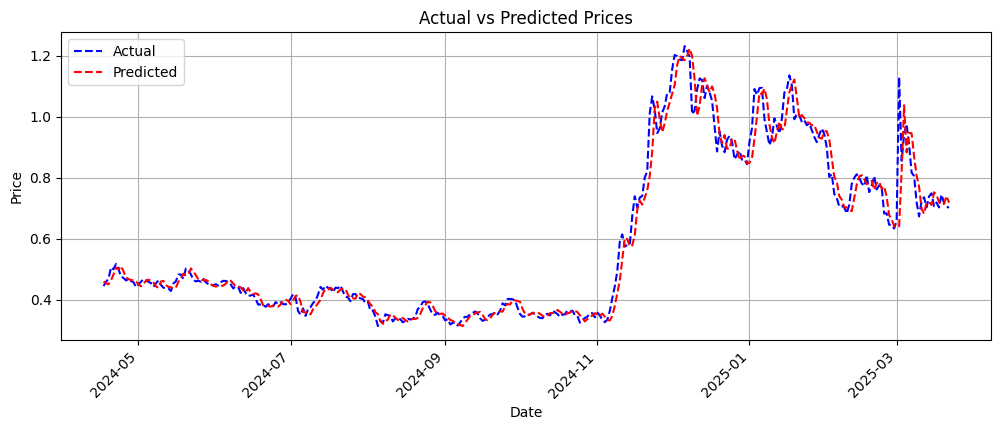

In [27]:
# Plot Actual vs Predicted prices
plt.figure(figsize=(12, 4))
plt.plot(error_df['Date'], error_df['Actual'], label='Actual', color='blue', linestyle='dashed')
plt.plot(error_df['Date'], error_df['Predicted'], label='Predicted', color='red', linestyle='dashed')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Actual vs Predicted Prices')
plt.legend()
plt.grid()
plt.show()

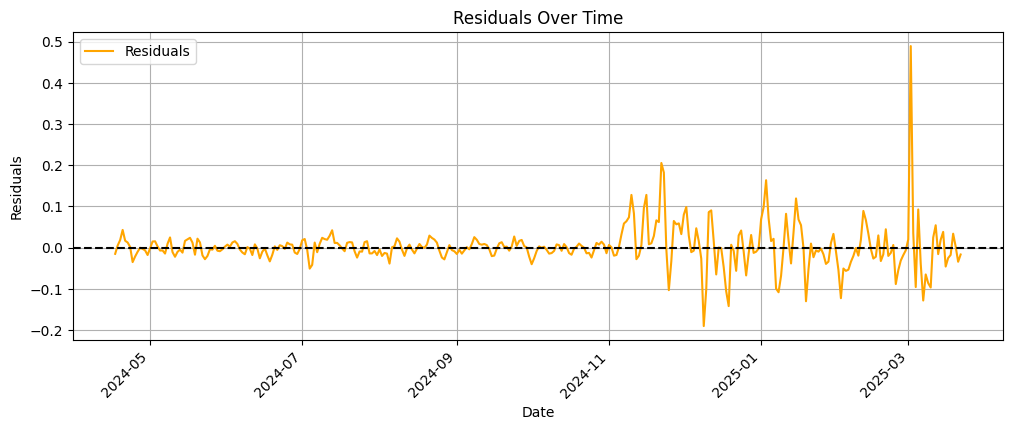

In [28]:
# Compute residuals
error_df['Residuals'] = error_df['Actual'] - error_df['Predicted']

# Plot Residuals Over Time
plt.figure(figsize=(12, 4))
plt.plot(error_df['Date'], error_df['Residuals'], color='orange', label='Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.legend()
plt.grid()
plt.xticks(rotation=45, ha='right')
plt.show()


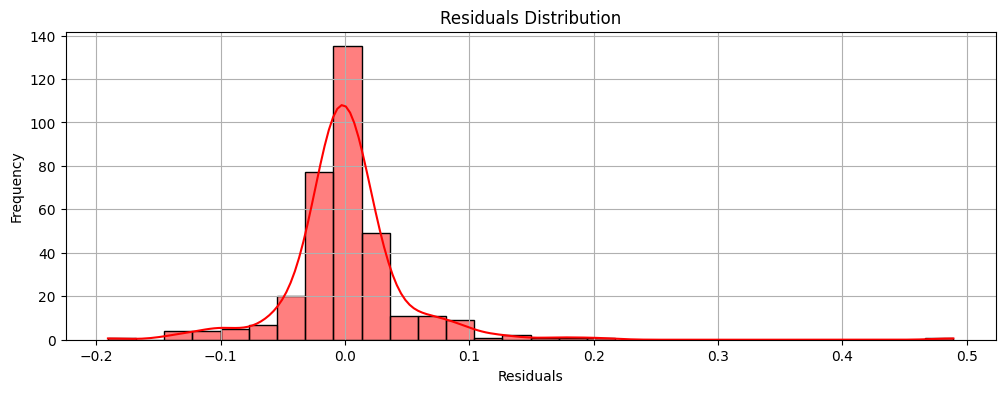

In [29]:
# Plot Residuals Distribution
plt.figure(figsize=(12, 4))
sns.histplot(error_df['Residuals'], bins=30, kde=True, color='red')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.grid()
plt.show()


In [30]:
# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(error_df['Actual'], error_df['Predicted'])

# Compute Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_actual, y_pred):
    mask = y_actual != 0  # Avoid division by zero
    return np.mean(np.abs((y_actual[mask] - y_pred[mask]) / y_actual[mask])) * 100

mape = mean_absolute_percentage_error(error_df['Actual'].values, error_df['Predicted'].values)

# Compute Weighted Mean Absolute Deviation (WMAD)
actual_values = error_df['Actual'].values
predicted_values = error_df['Predicted'].values

# Avoid division by zero by replacing zeros in actual values with a small number
actual_zero_adjusted = np.where(actual_values == 0, 1e-10, actual_values)
wmad = np.sum(np.abs(actual_values - predicted_values)) / np.sum(actual_zero_adjusted)

# Compute Average Accuracy
avg_accuracy = 1 - wmad

# Store error metrics in a DataFrame for easier reference
error_metrics = pd.DataFrame({
    'Metric': [
        'Mean Absolute Error (MAE)', 
        'Mean Absolute Percentage Error (MAPE)', 
        'Weighted Mean Absolute Deviation (WMAD)', 
        'Average Accuracy'
    ],
    'Value': [mae, mape, wmad, avg_accuracy]
})

# Print Error Metrics
print("\nError Analysis Metrics:")
print(error_metrics)



Error Analysis Metrics:
                                    Metric     Value
0                Mean Absolute Error (MAE)  0.028132
1    Mean Absolute Percentage Error (MAPE)  4.275322
2  Weighted Mean Absolute Deviation (WMAD)  0.047891
3                         Average Accuracy  0.952109


## prediction

In [32]:
import numpy as np
import pandas as pd
import yfinance as yf
import joblib
import tensorflow as tf
import mysql.connector
from datetime import datetime, timedelta
import re
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load Trained Model & Scaler
model = tf.keras.models.load_model('best_model_H_lstm.h5')
scaler = joblib.load('scaler_LH.pkl')

# Load NLP Model & Sentiment Analyzer
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
analyzer = SentimentIntensityAnalyzer()

# Load Loughran-McDonald Sentiment Dictionary
lm_positive = {"gain", "growth", "bullish", "opportunity", "profit", "surge", "expansion",
    "adoption", "approval", "partnership", "innovation", "mainstream", "rally",
    "institutional", "breakthrough", "stability", "strong", "all-time-high",
    "liquidity", "halving", "scarcity", "whale accumulation", "stake", "integration",
    "etf approval", "layer 2 scaling", "metaverse expansion", "positive outlook"}

lm_negative = {"crash", "loss", "bearish", "decline", "debt", "bankruptcy", "downturn",
    "regulatory crackdown", "ban", "fud", "lawsuit", "hacked", "ponzi",
    "liquidation", "fraud", "scam", "rug pull", "dumping", "sell-off",
    "volatility", "delisting", "depeg", "inflation", "recession", "exchange insolvency",
    "crypto winter", "negative outlook"}

# Preprocessing Functions
def preprocess_text(text):
    """Cleans, removes stopwords, and lemmatizes input text."""
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  
    text = re.sub(r"[^a-zA-Z\s]", "", text)  
    text = re.sub(r"\s+", " ", text).strip()  
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

def financial_sentiment_adjustment(text, vader_score):
    """Adjust sentiment score using the Loughran-McDonald financial lexicon."""
    words = text.split()
    adjustment = sum(0.2 if word in lm_positive else -0.2 if word in lm_negative else 0 for word in words)
    return max(min(vader_score + adjustment, 1), -1)

def preprocess_news(news_data):
    """Preprocess news headlines & descriptions, and extract sentiment scores."""
    news_data["cleaned_headline"] = news_data["headline"].astype(str).apply(preprocess_text)
    news_data["cleaned_description"] = news_data["description"].astype(str).apply(preprocess_text)

    news_data["VADER_Headline_Sentiment"] = news_data["cleaned_headline"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
    news_data["VADER_Description_Sentiment"] = news_data["cleaned_description"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

    news_data["Final_Headline_Sentiment"] = news_data.apply(
        lambda row: financial_sentiment_adjustment(row["cleaned_headline"], row["VADER_Headline_Sentiment"]), axis=1
    )
    news_data["Final_Description_Sentiment"] = news_data.apply(
        lambda row: financial_sentiment_adjustment(row["cleaned_description"], row["VADER_Description_Sentiment"]), axis=1
    )

    news_data["date"] = pd.to_datetime(news_data["date"], errors="coerce")
    return news_data[["date", "Final_Headline_Sentiment"]].drop_duplicates()

# Fetch Latest News Data
def fetch_latest_news():
    try:
        conn = mysql.connector.connect(
            host='localhost',
            user='root',
            password='Ariyarathne99@',
            database='crypto_news'
        )
        query = "SELECT date, headline, description FROM ada_news WHERE date >= CURDATE() - INTERVAL 2 DAY"
        news_data = pd.read_sql_query(query, conn)
        conn.close()

        if news_data.empty:
            # If no news today, fetch last available news
            query = "SELECT date, headline, description FROM ada_news ORDER BY date DESC LIMIT 1"
            conn = mysql.connector.connect(
                host='localhost',
                user='root',
                password='Ariyarathne99@',
                database='crypto_news'
            )
            last_news = pd.read_sql_query(query, conn)
            conn.close()
            news_data = last_news if not last_news.empty else pd.DataFrame(columns=["date", "headline", "description"])

        return news_data

    except mysql.connector.Error as err:
        print(f"Error fetching news: {err}")
        return pd.DataFrame(columns=["date", "headline", "description"])

news_data = fetch_latest_news()
news_data = preprocess_news(news_data)

# Get latest available sentiment (ONLY FROM DESCRIPTION)
if not news_data.empty:
    latest_sentiment = news_data["Final_Headline_Sentiment"].iloc[-1]
else:
    latest_sentiment = 0  # Default sentiment if no news available

# Fetch Latest Price Data
symbol = 'ADA-USD'
window_size = 2
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=window_size + 2)).strftime('%Y-%m-%d')

price_data = yf.download(symbol, start=start_date, end=end_date, interval='1d')
price_data.reset_index(inplace=True)
price_data = price_data[['Date', 'Close']].tail(window_size)  # Take last `window_size` rows

# Convert Date to Normal Format
price_data['Date'] = pd.to_datetime(price_data['Date']).dt.date
latest_prices = price_data['Close'].values

# Prepare Data for Prediction
sentiment_input = np.array([[latest_sentiment]] * window_size)  # Repeat latest sentiment
scaled_prices = scaler.transform(np.column_stack((sentiment_input, latest_prices)))

X_input = scaled_prices[:, 1].reshape(1, window_size, 1)  # Closing prices
sentiment_input = np.array([[latest_sentiment]]).reshape(1, 1, 1)  # Single latest sentiment score

# Combine Inputs
X_input = np.concatenate((X_input, sentiment_input), axis=1)

# Predict Next Day's Price
predicted_scaled_price = model.predict(X_input)
predicted_price = scaler.inverse_transform([[0, predicted_scaled_price[0][0]]])[0][1]

# Save Prediction
prediction_date = datetime.today().strftime('%Y-%m-%d')
print(f"Predicted Closing Price for {symbol} on {prediction_date}: ${predicted_price:.4f}")


C:\Users\acer\AppData\Local\Temp\ipykernel_20696\4005902131.py:79: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  news_data = pd.read_sql_query(query, conn)
C:\Users\acer\AppData\Local\Temp\ipykernel_20696\4005902131.py:91: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  last_news = pd.read_sql_query(query, conn)
[*********************100%***********************]  1 of 1 completed
C:\Users\acer\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicted Closing Price for ADA-USD on 2025-03-24: $0.6900
